# Training FFNN on ALL Three Datasets

In [1]:
import pandas as pd

diabetes_012_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_binary_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_health_indicators_BRFSS2015.csv'
diabetes_binary_5050split_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

# Load the CSV file
diabetes_012_health_indicators_BRFSS2015 = pd.read_csv(diabetes_012_health_indicators_BRFSS2015)
diabetes_binary_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_health_indicators_BRFSS2015)
diabetes_binary_5050split_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_5050split_health_indicators_BRFSS2015)

In [2]:
import seaborn as sns
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision import transforms
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    '''
    Plotting we used in the previous neural network assignment
    '''

    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training Accuracy', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation Accuracy', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [4]:
def confusion_plot_binary(model, inputs, labels, name=''):
    '''
    Visualize the confusion matrix data based on given labels and predictions
    
        Args:
            model: A PyTorch Neural Network model
                (PyTorch object)
            preds: An input feature that will be fed into the model
                (array-like)
            labels: Groundtruth labels
                (array-like)
            name: A title for the confusion matrix plot. Defaults to an empty string.
                (str)
        
        Returns:
            preds: Predicted class values based on the given input
                (array-like)
    '''

    model.eval()
    with torch.no_grad():
        preds = (model.forward(inputs) > 0.5).float()
    accuracy = accuracy_score(labels, preds)
    print(f'{name} accuracy: {accuracy * 100:.2f}')
    
    cf = confusion_matrix(labels, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap="Blues", fmt=".2f")
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    
    return preds

In [5]:
def confusion_plot_multiclass(model, inputs, labels, name='', classes=[0, 1, 2]):
    '''
    Visualize the confusion matrix data based on given labels and predictions
    
        Args:
            model: A PyTorch Neural Network model
                (PyTorch object)
            preds: An input feature that will be fed into the model
                (array-like)
            labels: Groundtruth labels
                (array-like)
            name: A title for the confusion matrix plot. Defaults to an empty string.
                (str)
            classes: A list of class names corresponding to the classes in the confusion matrix. Defaults to [0, 1, 2].
                (list)
        
        Returns:
            preds: Predicted class values based on the given input
                (array-like)
    '''
    model.eval()
    
    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1) 

    preds = preds
    labels = labels
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    print(f'{name} accuracy: {accuracy * 100:.2f}%')

    # Compute the confusion matrix
    cf = confusion_matrix(labels, preds, labels=classes, normalize='true')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt=".2f")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    return preds

### 1. FFNN on 5050-split Binary

In [6]:
# 5050-split binary dataset
# `diabetes_binary_5050split_health_indicators_BRFSS2015`
X_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.Diabetes_binary

X_train_diabetes01_5050, X_test_diabetes01_5050, y_train_diabetes01_5050, y_test_diabetes01_5050 = train_test_split(
    X_diabetes01_5050, y_diabetes01_5050, test_size=0.2, stratify=y_diabetes01_5050, random_state=11
)

# Convert to PyTorch tensors
X_train_diabetes01_5050_tensor = torch.tensor(X_train_diabetes01_5050.values, dtype=torch.float32)
X_test_diabetes01_5050_tensor = torch.tensor(X_test_diabetes01_5050.values, dtype=torch.float32)
y_train_diabetes01_5050_tensor = torch.tensor(y_train_diabetes01_5050.values, dtype=torch.float32)
y_test_diabetes01_5050_tensor = torch.tensor(y_test_diabetes01_5050.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset_diabetes01_5050 = TensorDataset(X_train_diabetes01_5050_tensor, y_train_diabetes01_5050_tensor)
test_dataset_diabetes01_5050 = TensorDataset(X_test_diabetes01_5050_tensor, y_test_diabetes01_5050_tensor)

# Create DataLoaders
train_loader_diabetes01_5050 = DataLoader(train_dataset_diabetes01_5050, batch_size=64, shuffle=True)
test_loader_diabetes01_5050 = DataLoader(test_dataset_diabetes01_5050, batch_size=64, shuffle=False)

In [7]:
num_features_diabetes01_5050 = X_diabetes01_5050.shape[1]
num_classes_diabetes01_5050 = y_diabetes01_5050.nunique()

In [8]:
class FFNN_diabetes01_5050(nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)

        # Neural Network Architecture
        self.dense1 = nn.Linear(in_features=num_features, out_features=64)
        self.activation1 = nn.Softplus()
        self.dense2 = nn.Linear(in_features=64, out_features=32)
        self.activation2 = nn.Softplus()
        self.dense3 = nn.Linear(in_features=32, out_features=1)
        self.activation3 = nn.Sigmoid()

    def forward(self, x):
        x = self.activation1(self.dense1(x))
        x = self.dropout(x)
        x = self.activation2(self.dense2(x))
        x = self.dropout(x)
        x = self.activation3(self.dense3(x))
        return x

In [9]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Current device is: {device}')
learning_rate = 0.00075
num_epochs=40

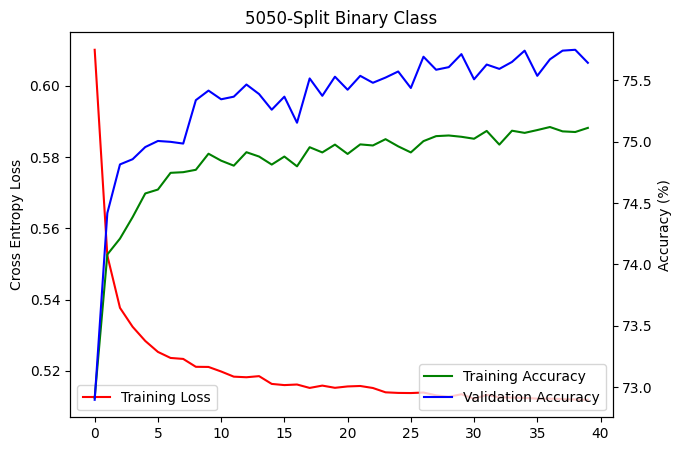

In [10]:
model1 = FFNN_diabetes01_5050(num_features_diabetes01_5050, num_classes_diabetes01_5050)
#model1.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adamax(
    model1.parameters(), 
    lr=learning_rate
)

losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model1.train()
    current_loss = 0
    
    for i, data in enumerate(train_loader_diabetes01_5050):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move the data to GPU
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model1(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update running loss
        current_loss += loss.item()
    
    # Find loss for current epoch
    average_loss = current_loss / len(train_loader_diabetes01_5050)
    losses.append(average_loss)

    # Set model to evaluation mode
    model1.eval()

    # Find training accuracy and test accuracy for current epoch
    train_predictions = []
    train_labels = []
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in train_loader_diabetes01_5050:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model1.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        for inputs, labels in test_loader_diabetes01_5050:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model1.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy()) 

    train_accuracies.append(accuracy_score(train_labels, train_predictions) * 100)
    test_accuracies.append(accuracy_score(test_labels, test_predictions) * 100)

    live_plot(np.array(losses), np.array(train_accuracies), test_accuracies, title='5050-Split Binary Class')

5050-Split Binary Class - Train accuracy: 75.11


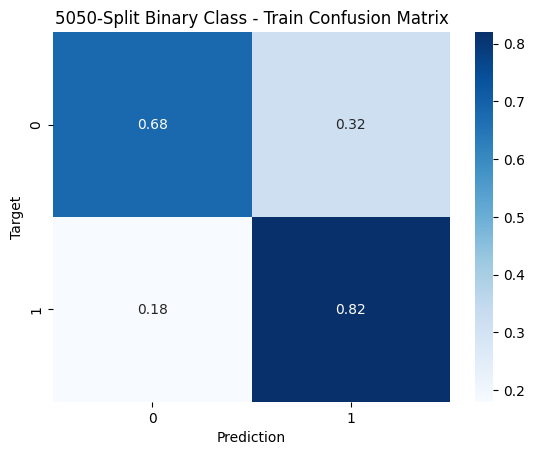

In [11]:
# Predict and plot on the training data
train_preds = confusion_plot_binary(
    model1, 
    X_train_diabetes01_5050_tensor, 
    y_train_diabetes01_5050, 
    '5050-Split Binary Class - Train'
)

5050-Split Binary Class - Validation accuracy: 75.64


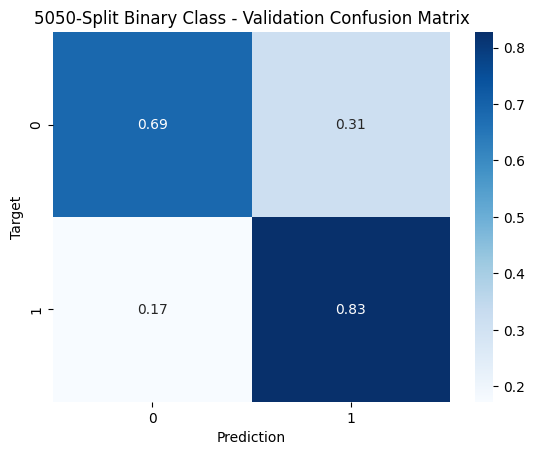

In [12]:
# Predict and plot on the validation data
val_preds = confusion_plot_binary(
    model1, 
    X_test_diabetes01_5050_tensor, 
    y_test_diabetes01_5050, 
    '5050-Split Binary Class - Validation'
)

### 2. FFNN on diabetes_012 Three Imbalanced Classes 

In [33]:
# diabetes012 dataset
# `diabetes_012_health_indicators_BRFSS2015`

# Deal with imbalance
df = diabetes_012_health_indicators_BRFSS2015

# Separate the data by class
class_0 = df[df['Diabetes_012'] == 0]
class_1 = df[df['Diabetes_012'] == 1]
class_2 = df[df['Diabetes_012'] == 2]

# Class 2 size
class_2_size = len(class_2)

# Randomly undersample class 0 to match the size of class 2 since class 0 has too many more observations
class_0_undersampled = class_0.sample(n=class_2_size, random_state=11)

# Randomly oversample class 1 to match the size of class 2 since class 1 has too little observations
class_1_oversampled = class_1.sample(n=class_2_size, random_state=11, replace=True)

# Combine the undersampled class 0 data with class 1 and class 2 data
df_sm = pd.concat([class_0_undersampled, class_1_oversampled, class_2])

# Shuffle the combined dataset
df_sm = df_sm.sample(frac=1, random_state=11).reset_index(drop=True)

# Split the features and labels
X_diabetes012_sm = df_sm.drop(['Diabetes_012'], axis=1)
y_diabetes012_sm = df_sm['Diabetes_012']

# diabetes012 dataset
# `diabetes_012_health_indicators_BRFSS2015`
X_diabetes012 = diabetes_012_health_indicators_BRFSS2015.drop(['Diabetes_012'], axis=1)
y_diabetes012 = diabetes_012_health_indicators_BRFSS2015.Diabetes_012

X_train_diabetes012_sm, X_test_diabetes012_sm, y_train_diabetes012_sm, y_test_diabetes012_sm = train_test_split(
    X_diabetes012_sm, y_diabetes012_sm, test_size=0.2, stratify=y_diabetes012_sm, random_state=11
)

X_train_diabetes012, X_test_diabetes012, y_train_diabetes012, y_test_diabetes012 = train_test_split(
    X_diabetes012, y_diabetes012, test_size=0.2, stratify=y_diabetes012, random_state=11
)

# Convert to PyTorch tensors
X_train_diabetes012_sm_tensor = torch.tensor(X_train_diabetes012_sm.values, dtype=torch.float32)
X_test_diabetes012_sm_tensor = torch.tensor(X_test_diabetes012_sm.values, dtype=torch.float32)
y_train_diabetes012_sm_tensor = torch.tensor(y_train_diabetes012_sm.values, dtype=torch.long)
y_test_diabetes012_sm_tensor = torch.tensor(y_test_diabetes012_sm.values, dtype=torch.long)

X_train_diabetes012_tensor = torch.tensor(X_train_diabetes012.values, dtype=torch.float32)
X_test_diabetes012_tensor = torch.tensor(X_test_diabetes012.values, dtype=torch.float32)
y_train_diabetes012_tensor = torch.tensor(y_train_diabetes012.values, dtype=torch.long)
y_test_diabetes012_tensor = torch.tensor(y_test_diabetes012.values, dtype=torch.long)

# Create TensorDatasets
train_dataset_diabetes012_sm = TensorDataset(X_train_diabetes012_sm_tensor, y_train_diabetes012_sm_tensor)
test_dataset_diabetes012_sm = TensorDataset(X_test_diabetes012_sm_tensor, y_test_diabetes012_sm_tensor)

train_dataset_diabetes012 = TensorDataset(X_train_diabetes012_tensor, y_train_diabetes012_tensor)
test_dataset_diabetes012 = TensorDataset(X_test_diabetes012_tensor, y_test_diabetes012_tensor)

# Create DataLoaders
train_loader_diabetes012_sm = DataLoader(train_dataset_diabetes012_sm, batch_size=128, shuffle=True)
test_loader_diabetes012_sm = DataLoader(test_dataset_diabetes012_sm, batch_size=128, shuffle=False)

train_loader_diabetes012 = DataLoader(train_dataset_diabetes012, batch_size=128, shuffle=True)
test_loader_diabetes012 = DataLoader(test_dataset_diabetes012, batch_size=128, shuffle=False)

In [34]:
num_features_diabetes012 = X_diabetes012_sm.shape[1]
num_classes_diabetes012 = y_diabetes012_sm.nunique()

In [35]:
class FFNN_diabetes012(nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Define dropout
        self.dropout = nn.Dropout(0.5)

        # Neural Network Architecture
        self.dense1 = nn.Linear(in_features=num_features, out_features=64)
        self.activation1 = nn.GELU()
        self.dense2 = nn.Linear(in_features=64, out_features=16)
        self.activation2 = nn.GELU()
        self.dense3 = nn.Linear(in_features=16, out_features=num_classes)

    def forward(self, x):
        x = self.activation1(self.dense1(x))
        x = self.dropout(x)
        x = self.activation2(self.dense2(x))
        x = self.dropout(x)
        x = self.dense3(x)
        return x

In [36]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Current device is: {device}')
learning_rate = 0.00025
num_epochs=30

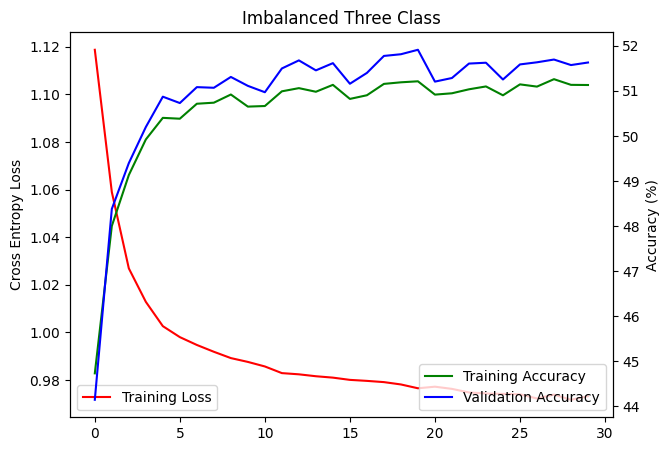

In [37]:
model2 = FFNN_diabetes012(num_features_diabetes012, num_classes_diabetes012)
#model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model2.parameters(), 
    lr=learning_rate
)

losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model2.train()
    current_loss = 0
    
    for i, data in enumerate(train_loader_diabetes012_sm):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move the data to GPU
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running loss
        current_loss += loss.item()
    
    # Find loss for current epoch
    average_loss = current_loss / len(train_loader_diabetes012_sm)
    losses.append(average_loss)

    # Set model to evaluation mode
    model2.eval()

    # Find training accuracy and test accuracy for current epoch
    train_predictions = []
    train_labels = []
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in train_loader_diabetes012_sm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model2.forward(inputs)
            predicted = torch.argmax(outputs, dim=1)

            # Collect predictions and labels
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        for inputs, labels in test_loader_diabetes012_sm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model2.forward(inputs)
            predicted = torch.argmax(outputs, dim=1)

            # Collect predictions and labels
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy()) 

    train_accuracies.append(accuracy_score(train_labels, train_predictions) * 100)
    test_accuracies.append(accuracy_score(test_labels, test_predictions) * 100)

    live_plot(np.array(losses), np.array(train_accuracies), test_accuracies, title='Imbalanced Three Class')

Imbalanced Three Class - Train accuracy: 51.13%


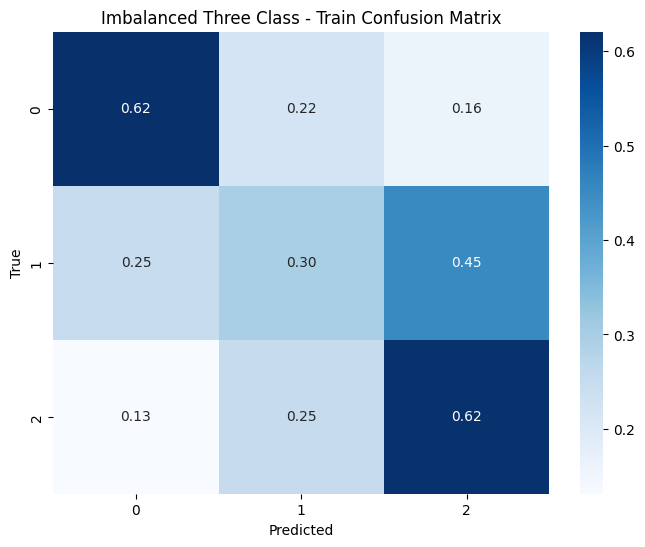

In [38]:
# Predict and plot on the undersampled training data
train_preds_012 = confusion_plot_multiclass(
    model2, 
    X_train_diabetes012_sm_tensor, 
    y_train_diabetes012_sm, 
    'Imbalanced Three Class - Train', 
    classes=[0, 1, 2]
)

Imbalanced Three Class - Validation accuracy: 61.36%


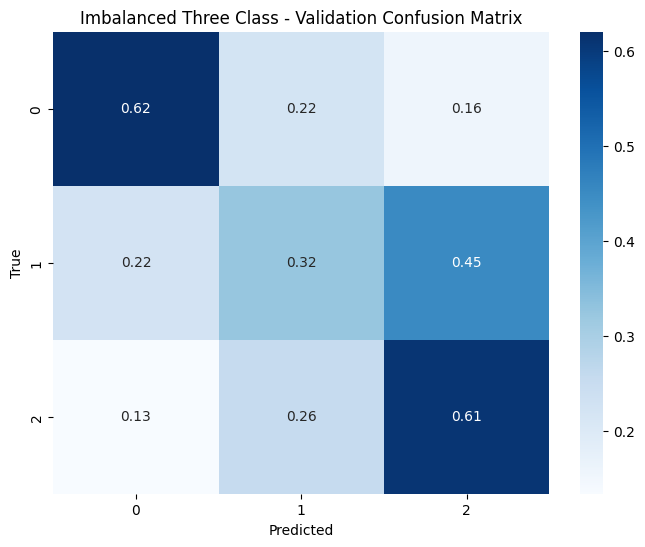

In [39]:
# Predict and plot on the original validation data
val_preds_012 = confusion_plot_multiclass(
    model2, 
    X_test_diabetes012_tensor, 
    y_test_diabetes012, 
    'Imbalanced Three Class - Validation', 
    classes=[0, 1, 2]
)

### 3. FFNN on Imbalanced Binary

In [20]:
# diabetes01 binary imbalanced dataset
# `diabetes_binary_health_indicators_BRFSS2015`

# Deal with imbalance
df = diabetes_binary_health_indicators_BRFSS2015

# Separate the data by class
class_0 = df[df['Diabetes_binary'] == 0]
class_1 = df[df['Diabetes_binary'] == 1]

# Class 1 size
class_1_size = len(class_1)

# Randomly undersample class 0 to match the size of class 1 since class 0 has too many more observations
class_0_undersampled = class_0.sample(n=class_1_size, random_state=11)

# Combine the undersampled class 0 data with class 1 data
df_sm = pd.concat([class_0_undersampled, class_1])

# Shuffle the combined dataset
df_sm = df_sm.sample(frac=1, random_state=11).reset_index(drop=True)

# Split the features and labels
X_diabetes_binary_sm = df_sm.drop(['Diabetes_binary'], axis=1)
y_diabetes_binary_sm = df_sm['Diabetes_binary']

# diabetes012 dataset
# `diabetes_012_health_indicators_BRFSS2015`
X_diabetes_binary = diabetes_binary_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes_binary = diabetes_binary_health_indicators_BRFSS2015.Diabetes_binary

X_train_diabetes_binary_sm, X_test_diabetes_binary_sm, y_train_diabetes_binary_sm, y_test_diabetes_binary_sm = train_test_split(
    X_diabetes_binary_sm, y_diabetes_binary_sm, test_size=0.2, stratify=y_diabetes_binary_sm, random_state=11
)

X_train_diabetes_binary, X_test_diabetes_binary, y_train_diabetes_binary, y_test_diabetes_binary = train_test_split(
    X_diabetes_binary, y_diabetes_binary, test_size=0.2, stratify=y_diabetes_binary, random_state=11
)

# Convert to PyTorch tensors
X_train_diabetes_binary_sm_tensor = torch.tensor(X_train_diabetes_binary_sm.values, dtype=torch.float32)
X_test_diabetes_binary_sm_tensor = torch.tensor(X_test_diabetes_binary_sm.values, dtype=torch.float32)
y_train_diabetes_binary_sm_tensor = torch.tensor(y_train_diabetes_binary_sm.values, dtype=torch.float32)
y_test_diabetes_binary_sm_tensor = torch.tensor(y_test_diabetes_binary_sm.values, dtype=torch.float32)

X_train_diabetes_binary_tensor = torch.tensor(X_train_diabetes_binary.values, dtype=torch.float32)
X_test_diabetes_binary_tensor = torch.tensor(X_test_diabetes_binary.values, dtype=torch.float32)
y_train_diabetes_binary_tensor = torch.tensor(y_train_diabetes_binary.values, dtype=torch.float32)
y_test_diabetes_binary_tensor = torch.tensor(y_test_diabetes_binary.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset_diabetes_binary_sm = TensorDataset(X_train_diabetes_binary_sm_tensor, y_train_diabetes_binary_sm_tensor)
test_dataset_diabetes_binary_sm = TensorDataset(X_test_diabetes_binary_sm_tensor, y_test_diabetes_binary_sm_tensor)

train_dataset_diabetes_binary = TensorDataset(X_train_diabetes_binary_tensor, y_train_diabetes_binary_tensor)
test_dataset_diabetes_binary = TensorDataset(X_test_diabetes_binary_tensor, y_test_diabetes_binary_tensor)

# Create DataLoaders
train_loader_diabetes_binary_sm = DataLoader(train_dataset_diabetes_binary_sm, batch_size=128, shuffle=True)
test_loader_diabetes_binary_sm = DataLoader(test_dataset_diabetes_binary_sm, batch_size=128, shuffle=False)

train_loader_diabetes_binary = DataLoader(train_dataset_diabetes_binary, batch_size=128, shuffle=True)
test_loader_diabetes_binary = DataLoader(test_dataset_diabetes_binary, batch_size=128, shuffle=False)

In [21]:
num_features_diabetes_binary = X_diabetes_binary.shape[1]
num_classes_diabetes_binary = y_diabetes_binary.nunique()

In [22]:
class FFNN_diabete_binary(nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Define dropout layer
        self.dropout = nn.Dropout(0.25)

        # Neural Network Architecture
        self.dense1 = nn.Linear(in_features=num_features, out_features=64)
        self.activation1 = nn.Softplus()
        self.dense2 = nn.Linear(in_features=64, out_features=16)
        self.activation2 = nn.Softplus()
        self.dense3 = nn.Linear(in_features=16, out_features=1)
        self.activation3 = nn.Sigmoid()

    def forward(self, x):
        x = self.activation1(self.dense1(x))
        x = self.dropout(x)
        x = self.activation2(self.dense2(x))
        x = self.dropout(x)
        x = self.activation3(self.dense3(x))
        
        return x

In [23]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Current device is: {device}')
learning_rate = 0.0005
num_epochs=30

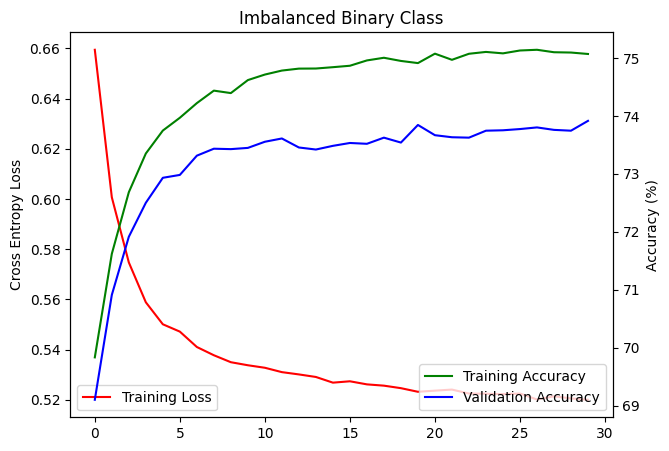

In [24]:
model3 = FFNN_diabete_binary(num_features_diabetes_binary, num_classes_diabetes_binary)
#model3.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adamax(
    model3.parameters(), 
    lr=learning_rate
)

losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model3.train()
    current_loss = 0
    
    for i, data in enumerate(train_loader_diabetes_binary_sm):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move the data to GPU
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model3(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update running loss
        current_loss += loss.item()
    
    # Find loss for current epoch
    average_loss = current_loss / len(train_loader_diabetes_binary_sm)
    losses.append(average_loss)

    # Set model to evaluation mode
    model3.eval()

    # Find training accuracy and test accuracy for current epoch
    train_predictions = []
    train_labels = []
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in train_loader_diabetes_binary_sm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model3.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        for inputs, labels in test_loader_diabetes_binary_sm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model3.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy()) 

    train_accuracies.append(accuracy_score(train_labels, train_predictions) * 100)
    test_accuracies.append(accuracy_score(test_labels, test_predictions) * 100)

    live_plot(np.array(losses), np.array(train_accuracies), test_accuracies, title='Imbalanced Binary Class')

Imbalanced Binary Class - Train accuracy: 75.07


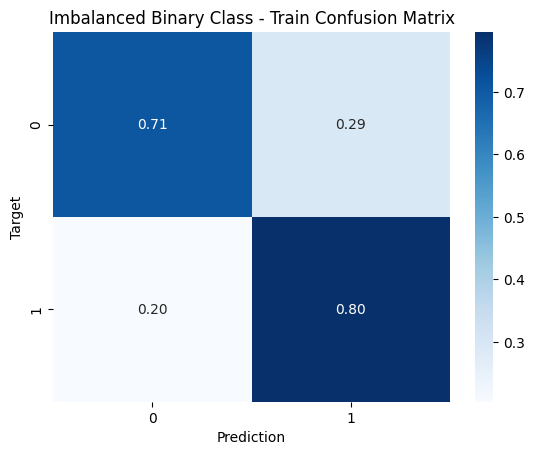

In [25]:
# Predict and plot on the undersampled training data
train_preds_binary = confusion_plot_binary(
    model3, 
    X_train_diabetes_binary_sm_tensor, 
    y_train_diabetes_binary_sm, 
    'Imbalanced Binary Class - Train'
)

Imbalanced Binary Class - Validation accuracy: 70.99


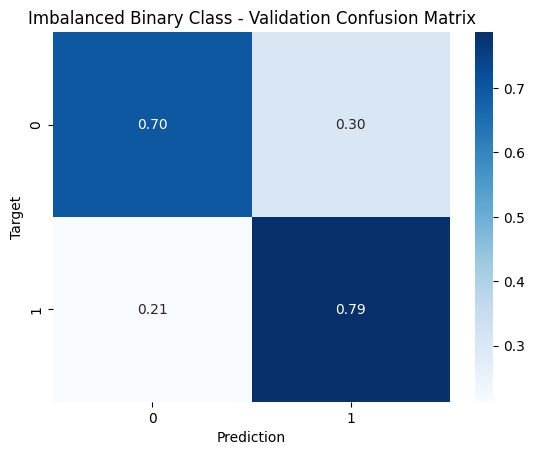

In [26]:
# Predict and plot on the original validation data
val_preds_binary = confusion_plot_binary(
    model3, 
    X_test_diabetes_binary_tensor, 
    y_test_diabetes_binary, 
    'Imbalanced Binary Class - Validation'
)

##### Let us try using NearMiss to deal with imbalance

* Other studies used NearMiss() method to deal with imbalance and returned promising result. However, their implementation was questionable since the model was tested based on the validation set after applying NearMiss(). 

* Our model below was trained on NearMiss() pre-processed data, and tested on the original dataset. It turned out that although the model performed well on the NearMiss() pre-processed data, it performed significantly worse on the original dataset.

In [27]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=1, n_neighbors=10)

# Split the features and labels
X_diabetes_binary_nm, y_diabetes_binary_nm = nm.fit_resample(X_diabetes_binary, y_diabetes_binary)

X_train_diabetes_binary_nm, X_test_diabetes_binary_nm, y_train_diabetes_binary_nm, y_test_diabetes_binary_nm = train_test_split(
    X_diabetes_binary_nm, y_diabetes_binary_nm, test_size=0.2, stratify=y_diabetes_binary_nm, random_state=11
)

# Convert to PyTorch tensors
X_train_diabetes_binary_nm_tensor = torch.tensor(X_train_diabetes_binary_nm.values, dtype=torch.float32)
X_test_diabetes_binary_nm_tensor = torch.tensor(X_test_diabetes_binary_nm.values, dtype=torch.float32)
y_train_diabetes_binary_nm_tensor = torch.tensor(y_train_diabetes_binary_nm.values, dtype=torch.float32)
y_test_diabetes_binary_nm_tensor = torch.tensor(y_test_diabetes_binary_nm.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset_diabetes_binary_nm = TensorDataset(X_train_diabetes_binary_nm_tensor, y_train_diabetes_binary_nm_tensor)
test_dataset_diabetes_binary_nm = TensorDataset(X_test_diabetes_binary_nm_tensor, y_test_diabetes_binary_nm_tensor)

# Create DataLoaders
train_loader_diabetes_binary_nm = DataLoader(train_dataset_diabetes_binary_nm, batch_size=128, shuffle=True)
test_loader_diabetes_binary_nm = DataLoader(test_dataset_diabetes_binary_nm, batch_size=128, shuffle=False)

In [28]:
class FFNN_diabete_binary_nm(nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = nn.Linear(in_features=num_features, out_features=64)
        self.activation1 = nn.Softplus()
        self.dense2 = nn.Linear(in_features=64, out_features=1)
        self.activation2 = nn.Sigmoid()

    def forward(self, x):
        x = self.activation1(self.dense1(x))
        x = self.activation2(self.dense2(x))
        
        return x

In [29]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f'Current device is: {device}')
learning_rate = 0.0005
num_epochs=20

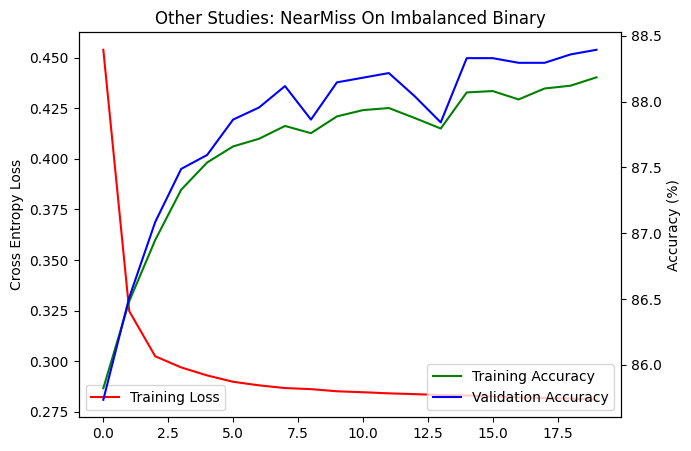

In [30]:
model4 = FFNN_diabete_binary_nm(num_features_diabetes_binary, num_classes_diabetes_binary)
#model4.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adamax(
    model4.parameters(), 
    lr=learning_rate
)

losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model4.train()
    current_loss = 0
    
    for i, data in enumerate(train_loader_diabetes_binary_nm):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move the data to GPU
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model4(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update running loss
        current_loss += loss.item()
    
    # Find loss for current epoch
    average_loss = current_loss / len(train_loader_diabetes_binary_nm)
    losses.append(average_loss)

    # Set model to evaluation mode
    model4.eval()

    # Find training accuracy and test accuracy for current epoch
    train_predictions = []
    train_labels = []
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in train_loader_diabetes_binary_nm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model4.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        for inputs, labels in test_loader_diabetes_binary_nm:
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            # Pass forward
            outputs = model4.forward(inputs)
            predicted = (outputs > 0.5).float()

            # Collect predictions and labels
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy()) 

    train_accuracies.append(accuracy_score(train_labels, train_predictions) * 100)
    test_accuracies.append(accuracy_score(test_labels, test_predictions) * 100)

    live_plot(np.array(losses), np.array(train_accuracies), test_accuracies, title='Other Studies: NearMiss On Imbalanced Binary')

Other Studies: NearMiss On Imbalanced Binary - Train accuracy: 88.18


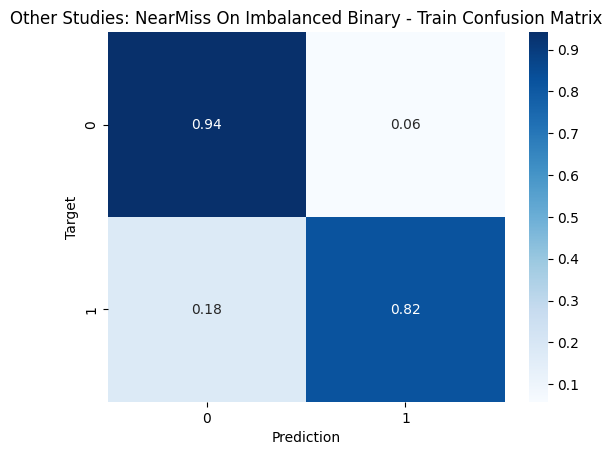

In [31]:
# Predict and plot on the NearMiss training data 
train_preds_binary_nm = confusion_plot_binary(
    model4, 
    X_train_diabetes_binary_nm_tensor, 
    y_train_diabetes_binary_nm, 
    'Other Studies: NearMiss On Imbalanced Binary - Train'
)

Other Studies: NearMiss On Imbalanced Binary - Valid accuracy: 45.99


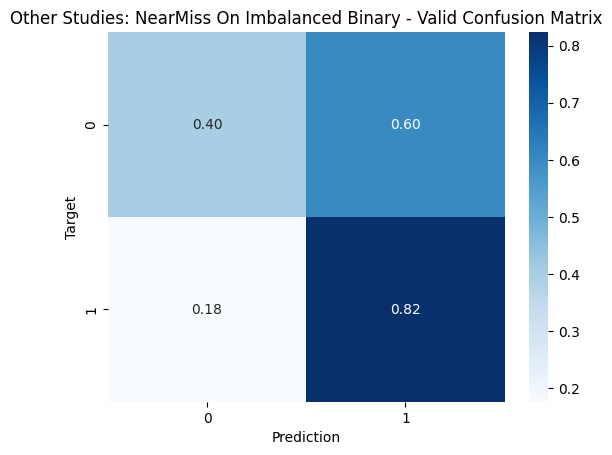

In [32]:
# Predict and plot on the original validation data
val_preds_binary_nm = confusion_plot_binary(
    model4, 
    X_test_diabetes_binary_tensor, 
    y_test_diabetes_binary, 
    'Other Studies: NearMiss On Imbalanced Binary - Valid'
)